## MA 544 Spring 2021: Programming Assignment - 4
---


In [17]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as pt
from typing import Iterable, List

### Question 1
---
Find the nonnegative basis representation of images from one of the following databases. Show a comparison of some sample images with their reconstruction from the basis.

>- The ORL database of faces at [ORL link](http://cam-orl.co.uk/facedatabase.html/#:~:text=Our%20Database%20of%20Faces%2C%20%28formerly%20%27The%20ORL%20Database,Robotics%20Group%20of%20the%20Cambridge%20University%20Engineering%20Department.).

>- The CBCL database of faces at [MIT link](http://cbcl.mit.edu/software-datasets/heisele/facerecognition-database.html).

>- Yale faces B facial images at [UCSD](http://vision.ucsd.edu/~leekc/ExtYaleDatabase/ExtYaleB.html).

In [2]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [3]:
# to avoid having to write code to fully parse the data by subject I 
# will write it to handle a single subject, yaleB01
data_folder: str = os.path.join('data', 'CroppedYale', 'yaleB01')

In [4]:
class PGMReader():
    def __init__(self, filepath, mode):
        assert filepath.split('.')[-1] == 'pgm'
        self.filepath = filepath
        self.mode = mode
        
    def __enter__(self):
        # return the file object after opening and setting it up
        self.pgm_image = open(self.filepath, self.mode)
        return self.read_pgm(self.pgm_image)
    
    def __exit__(self, type, value, traceback):
        self.pgm_image.close()
    
    def read_pgm(self, pgmf):
        """Return a raster of integers from a PGM as a list of lists."""
        assert pgmf.readline() == b'P5\n'
        (width, height) = [int(i) for i in pgmf.readline().split()]
        depth = int(pgmf.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(pgmf.read(1)))
            raster.append(row)
        return np.array(raster)

Shape of images: (192, 168)


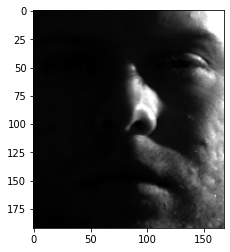

In [5]:
m, n = 192, 168
filepaths = list_files(data_folder, '*.pgm')
images = np.zeros((m*n, len(filepaths)))
for i, filepath in enumerate(filepaths):
    with PGMReader(filepath, 'rb') as image:
        images[:, i] = image.reshape((m*n,))
        
print(f"Shape of images: ({m}, {n})")
pt.imshow(images[:, 2].reshape((m, n)), cmap='gray')

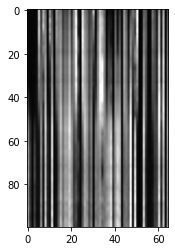

In [6]:
pt.imshow(images[:100, :], cmap='gray')

In [14]:
class LSNMF():
    def __init__(self, M):
        self.m, self.n = M.shape
        self.M = M
    
    def fit(self, threshold = 5e3, max_iter = 200):
        # initialize a random start state for W and H
        W = np.random.rand(self.m, self.n)
        H = np.random.rand(self.n, self.n)
        
        # @ delineates matrix multiplication
        # np.multiply delineates elementwise mutliplication
        # np.divide delineates elementwise division
        for i in range(max_iter):
            norm = np.linalg.norm(self.M - W @ H)
            if i % 50 == 0 or i == max_iter:
                print(f'Norm for iteration {i}: {norm}')
            if norm < threshold:
                print("Reached convergence through threshold")
                break
                
            wktv = np.dot(W.T, self.M)
            wktwk = np.dot(W.T, W)
            wktwkhk = np.dot(wktwk, H)
            
            H_kp1 = np.multiply(H, np.divide(wktv, wktwkhk))
            
            vhkp1t = np.dot(self.M, H_kp1.T)
            wkhkp1 = np.dot(W, H_kp1)
            wkhkp1hkp1t = np.dot(wkhkp1, H_kp1.T)
            
            W_kp1 = np.multiply(W, np.divide(vhkp1t, wkhkp1hkp1t))
            
            H = H_kp1
            W = W_kp1
            
            if i == max_iter-1:
                print("Reached convergence through max_iter")
        
        return W, H

In [8]:
lsnmf = LSNMF(images)

In [9]:
W, H = lsnmf.fit()

Norm for iteration 0: 123804.72523226909
Norm for iteration 50: 13279.60973509328
Norm for iteration 100: 10260.641220581652
Norm for iteration 150: 8711.207676457394
Reached convergence through max_iter


### Original Image

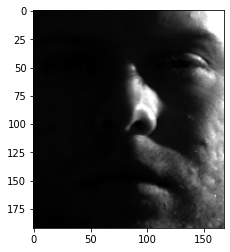

In [10]:
# original image 2
pt.imshow(images[:, 2].reshape(m, n), cmap='gray')

### NMF Reconstruction using the Lee-Seung Algorithm

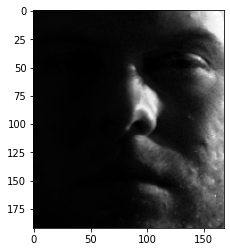

In [11]:
combinations = H[:, 2]
reconstruction = W @ combinations
pt.imshow(reconstruction.reshape(m, n), cmap='gray')

### Question 2
---
Set up a linear regression model for the miles per gallon on the data at automobile [UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/).  Discard the categorical data.

>1. Analyze the data to get relevant insight.
>1. Get feature matrix X, and target variable y.
>1. Split data into training and testing.
>1. Normalize data using MinMaxScaler.
>1. Creat a LinearRegression object for modeling.
>1. Train the model with training data.
>1. Look at R^2 score for the goodness of fit for the train and test data.
>1. Present a graphical comparison of true and observed responses for the test data.
>1. Improve the performance of your model on the test data.

In [18]:
data_folder: str = os.path.join('data')

In [28]:
data = pd.read_csv(os.path.join(data_folder,'auto-mpg.data'),
                                 delim_whitespace=True,
                                 header=None)
column_names = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
data.columns = column_names
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [30]:
data.describe()

,mpg,cylinders,displacement,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


### Question 3
---
Setup a logistic regression model on the data at [adultUCI](http://archive.ics.uci.edu/ml/datasets/Adult).  Discuss the performance of your model using appropriate statistics. Use dummy variables to handle categorical variables. 

>1. Prepare the data. Create dummy variables for categorical variables. [See this](https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example)
>1. Analyze the data to get relevant insight.
>2. Get feature matrix X, and target variable y (>50k or <50k)
>3. Split data into training and testing
>4. Normalize data using MinMaxScaler
>5. Creat a LogisticRegression object for modeling
>6. Train the model with training data
>7. Compare the precision, recall, and F1-score on the train and test data.
>1. Improve the performance of your model on the test data.

In [13]:
# Your code comes here